In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [4]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [5]:
forecasting = 20

In [6]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [7]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

<AxesSubplot:>

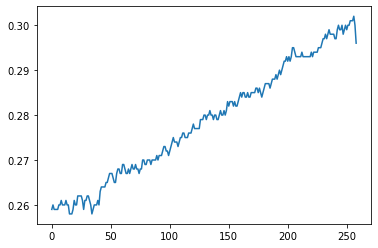

In [8]:
df.plot()

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [10]:
train = df_scaled

In [11]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [12]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [13]:
x_train.shape

(191, 20, 1)

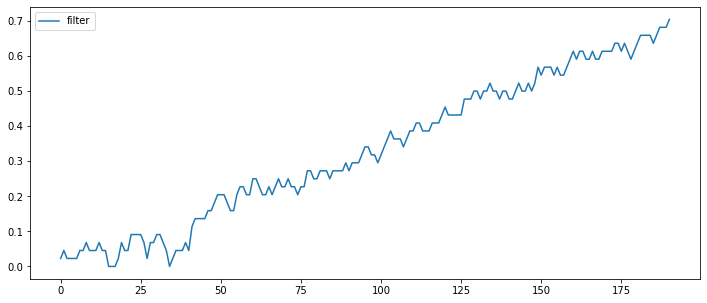

In [14]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

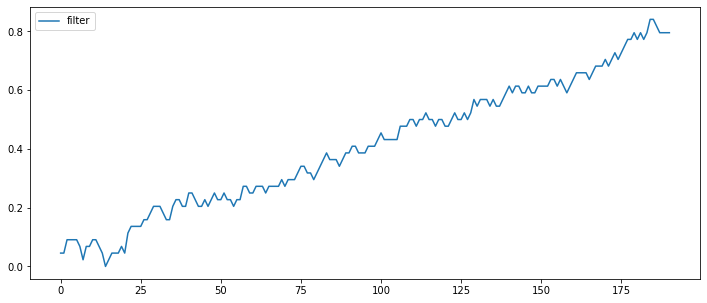

In [15]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [16]:
OUT_STEPS = 20

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [18]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
12/12 [==============================] - 2s 7ms/step - loss: 0.1750 - mean_absolute_error: 0.3569
Epoch 2/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.1384 - mean_absolute_error: 0.3142
Epoch 3/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.1043 - mean_absolute_error: 0.2662
Epoch 4/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0565 - mean_absolute_error: 0.1899
Epoch 5/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0314 - mean_absolute_error: 0.1458
Epoch 6/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0181 - mean_absolute_error: 0.1119
Epoch 7/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.0108 - mean_absolute_error: 0.0848
Epoch 8/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0065 - mean_absolute_error: 0.0644
Epoch 9/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0414
E

12/12 [==============================] - 0s 7ms/step - loss: 5.6265e-04 - mean_absolute_error: 0.0186
Epoch 72/1000
12/12 [==============================] - 0s 7ms/step - loss: 5.3968e-04 - mean_absolute_error: 0.0183
Epoch 73/1000
12/12 [==============================] - 0s 7ms/step - loss: 5.7544e-04 - mean_absolute_error: 0.0188
Epoch 74/1000
12/12 [==============================] - 0s 9ms/step - loss: 5.1201e-04 - mean_absolute_error: 0.0180
Epoch 75/1000
12/12 [==============================] - 0s 7ms/step - loss: 5.1139e-04 - mean_absolute_error: 0.0181
Epoch 76/1000
12/12 [==============================] - 0s 7ms/step - loss: 5.3244e-04 - mean_absolute_error: 0.0183A: 0s - loss: 5.3496e-04 - mean_absolute_error: 0.018
Epoch 77/1000
12/12 [==============================] - 0s 9ms/step - loss: 5.5558e-04 - mean_absolute_error: 0.0187
Epoch 78/1000
12/12 [==============================] - 0s 7ms/step - loss: 5.2505e-04 - mean_absolute_error: 0.0182
Epoch 79/1000
12/12 [============

12/12 [==============================] - 0s 8ms/step - loss: 4.6368e-04 - mean_absolute_error: 0.0173
Epoch 141/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.5702e-04 - mean_absolute_error: 0.0172
Epoch 142/1000
12/12 [==============================] - 0s 6ms/step - loss: 4.6227e-04 - mean_absolute_error: 0.0173
Epoch 143/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.6709e-04 - mean_absolute_error: 0.0174
Epoch 144/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.7381e-04 - mean_absolute_error: 0.0176
Epoch 145/1000
12/12 [==============================] - 0s 6ms/step - loss: 4.8137e-04 - mean_absolute_error: 0.0176
Epoch 146/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.8086e-04 - mean_absolute_error: 0.0175
Epoch 147/1000
12/12 [==============================] - 0s 8ms/step - loss: 4.8866e-04 - mean_absolute_error: 0.0178
Epoch 148/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.8

12/12 [==============================] - 0s 7ms/step - loss: 4.3920e-04 - mean_absolute_error: 0.0170
Epoch 210/1000
12/12 [==============================] - 0s 8ms/step - loss: 4.2455e-04 - mean_absolute_error: 0.0167
Epoch 211/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.4877e-04 - mean_absolute_error: 0.0171
Epoch 212/1000
12/12 [==============================] - 0s 8ms/step - loss: 4.6793e-04 - mean_absolute_error: 0.0174
Epoch 213/1000
12/12 [==============================] - 0s 8ms/step - loss: 4.4660e-04 - mean_absolute_error: 0.0171
Epoch 214/1000
12/12 [==============================] - 0s 8ms/step - loss: 4.4604e-04 - mean_absolute_error: 0.0172
Epoch 215/1000
12/12 [==============================] - 0s 11ms/step - loss: 4.4983e-04 - mean_absolute_error: 0.0171
Epoch 216/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.2523e-04 - mean_absolute_error: 0.0166
Epoch 217/1000
12/12 [==============================] - 0s 9ms/step - loss: 4.

12/12 [==============================] - 0s 7ms/step - loss: 4.1530e-04 - mean_absolute_error: 0.0164
Epoch 280/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.2218e-04 - mean_absolute_error: 0.0165
Epoch 281/1000
12/12 [==============================] - 0s 8ms/step - loss: 4.1929e-04 - mean_absolute_error: 0.0165
Epoch 282/1000
12/12 [==============================] - 0s 9ms/step - loss: 4.1211e-04 - mean_absolute_error: 0.0164
Epoch 283/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.2782e-04 - mean_absolute_error: 0.0166
Epoch 284/1000
12/12 [==============================] - 0s 8ms/step - loss: 4.0856e-04 - mean_absolute_error: 0.0164
Epoch 285/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.2209e-04 - mean_absolute_error: 0.0166
Epoch 286/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.3568e-04 - mean_absolute_error: 0.0169
Epoch 287/1000
12/12 [==============================] - 0s 7ms/step - loss: 4.0

12/12 [==============================] - 0s 8ms/step - loss: 4.0935e-04 - mean_absolute_error: 0.0163
Epoch 350/1000
12/12 [==============================] - 0s 9ms/step - loss: 4.0411e-04 - mean_absolute_error: 0.0161
Epoch 351/1000
12/12 [==============================] - 0s 6ms/step - loss: 4.1510e-04 - mean_absolute_error: 0.0164
Epoch 352/1000
12/12 [==============================] - 0s 10ms/step - loss: 4.0339e-04 - mean_absolute_error: 0.0162
Epoch 353/1000
12/12 [==============================] - 0s 6ms/step - loss: 4.1962e-04 - mean_absolute_error: 0.0166
Epoch 354/1000
12/12 [==============================] - 0s 7ms/step - loss: 3.9117e-04 - mean_absolute_error: 0.0160
Epoch 355/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.9461e-04 - mean_absolute_error: 0.0161
Epoch 356/1000
12/12 [==============================] - 0s 8ms/step - loss: 4.2367e-04 - mean_absolute_error: 0.0166
Epoch 357/1000
12/12 [==============================] - 0s 6ms/step - loss: 4.

12/12 [==============================] - 0s 5ms/step - loss: 3.9848e-04 - mean_absolute_error: 0.0160
Epoch 419/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.0375e-04 - mean_absolute_error: 0.0163
Epoch 420/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.9932e-04 - mean_absolute_error: 0.0162
Epoch 421/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.1005e-04 - mean_absolute_error: 0.0163
Epoch 422/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.9061e-04 - mean_absolute_error: 0.0159
Epoch 423/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.7527e-04 - mean_absolute_error: 0.0157
Epoch 424/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.9054e-04 - mean_absolute_error: 0.0159
Epoch 425/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.1232e-04 - mean_absolute_error: 0.0164
Epoch 426/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.8

12/12 [==============================] - 0s 4ms/step - loss: 3.9835e-04 - mean_absolute_error: 0.0160
Epoch 488/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.9231e-04 - mean_absolute_error: 0.0160
Epoch 489/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.8125e-04 - mean_absolute_error: 0.0157
Epoch 490/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.7916e-04 - mean_absolute_error: 0.0157
Epoch 491/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.7161e-04 - mean_absolute_error: 0.0156
Epoch 492/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6990e-04 - mean_absolute_error: 0.0155
Epoch 493/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.8413e-04 - mean_absolute_error: 0.0158
Epoch 494/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.7019e-04 - mean_absolute_error: 0.0156
Epoch 495/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.7

12/12 [==============================] - 0s 5ms/step - loss: 3.7318e-04 - mean_absolute_error: 0.0155
Epoch 557/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.4050e-04 - mean_absolute_error: 0.0149
Epoch 558/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.3955e-04 - mean_absolute_error: 0.0149
Epoch 559/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.4725e-04 - mean_absolute_error: 0.0150
Epoch 560/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.5331e-04 - mean_absolute_error: 0.0151
Epoch 561/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6714e-04 - mean_absolute_error: 0.0155
Epoch 562/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.5315e-04 - mean_absolute_error: 0.0152
Epoch 563/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.5637e-04 - mean_absolute_error: 0.0152
Epoch 564/1000
12/12 [==============================] - 0s 6ms/step - loss: 3.5

12/12 [==============================] - 0s 5ms/step - loss: 3.3733e-04 - mean_absolute_error: 0.0147
Epoch 627/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.2665e-04 - mean_absolute_error: 0.0146
Epoch 628/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.3263e-04 - mean_absolute_error: 0.0146
Epoch 629/1000
12/12 [==============================] - ETA: 0s - loss: 3.2889e-04 - mean_absolute_error: 0.014 - 0s 6ms/step - loss: 3.2824e-04 - mean_absolute_error: 0.0146
Epoch 630/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.2530e-04 - mean_absolute_error: 0.0146
Epoch 631/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.3917e-04 - mean_absolute_error: 0.0148
Epoch 632/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.3423e-04 - mean_absolute_error: 0.0147
Epoch 633/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.2609e-04 - mean_absolute_error: 0.0146
Epoch 634/1000
12/12 

12/12 [==============================] - 0s 4ms/step - loss: 3.1567e-04 - mean_absolute_error: 0.0142
Epoch 696/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.1074e-04 - mean_absolute_error: 0.0142
Epoch 697/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0686e-04 - mean_absolute_error: 0.0140
Epoch 698/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2291e-04 - mean_absolute_error: 0.0144
Epoch 699/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.1991e-04 - mean_absolute_error: 0.0143
Epoch 700/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0571e-04 - mean_absolute_error: 0.0140
Epoch 701/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0647e-04 - mean_absolute_error: 0.0141
Epoch 702/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0627e-04 - mean_absolute_error: 0.0140
Epoch 703/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.1

12/12 [==============================] - 0s 5ms/step - loss: 3.0682e-04 - mean_absolute_error: 0.0141
Epoch 764/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0659e-04 - mean_absolute_error: 0.0141
Epoch 765/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0193e-04 - mean_absolute_error: 0.0139
Epoch 766/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0480e-04 - mean_absolute_error: 0.0140
Epoch 767/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.9367e-04 - mean_absolute_error: 0.0138
Epoch 768/1000
12/12 [==============================] - 0s 6ms/step - loss: 3.0812e-04 - mean_absolute_error: 0.0141
Epoch 769/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9216e-04 - mean_absolute_error: 0.0137
Epoch 770/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0136e-04 - mean_absolute_error: 0.0140
Epoch 771/1000
12/12 [==============================] - 0s 6ms/step - loss: 2.8

12/12 [==============================] - 0s 5ms/step - loss: 2.8199e-04 - mean_absolute_error: 0.0135
Epoch 834/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9646e-04 - mean_absolute_error: 0.0137
Epoch 835/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.8504e-04 - mean_absolute_error: 0.0135
Epoch 836/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.8213e-04 - mean_absolute_error: 0.0134
Epoch 837/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9352e-04 - mean_absolute_error: 0.0137
Epoch 838/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.8658e-04 - mean_absolute_error: 0.0135
Epoch 839/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.8692e-04 - mean_absolute_error: 0.0136
Epoch 840/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.7492e-04 - mean_absolute_error: 0.0133
Epoch 841/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9

12/12 [==============================] - 0s 4ms/step - loss: 2.8388e-04 - mean_absolute_error: 0.0134
Epoch 904/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.8093e-04 - mean_absolute_error: 0.0134
Epoch 905/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.8013e-04 - mean_absolute_error: 0.0134
Epoch 906/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7093e-04 - mean_absolute_error: 0.0132
Epoch 907/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.8657e-04 - mean_absolute_error: 0.0134
Epoch 908/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.8682e-04 - mean_absolute_error: 0.0136
Epoch 909/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.8656e-04 - mean_absolute_error: 0.0136
Epoch 910/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7219e-04 - mean_absolute_error: 0.0132
Epoch 911/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7

12/12 [==============================] - 0s 5ms/step - loss: 2.7841e-04 - mean_absolute_error: 0.0133
Epoch 974/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.8041e-04 - mean_absolute_error: 0.0133
Epoch 975/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.7958e-04 - mean_absolute_error: 0.0133
Epoch 976/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.6874e-04 - mean_absolute_error: 0.0131
Epoch 977/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7223e-04 - mean_absolute_error: 0.0132
Epoch 978/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7421e-04 - mean_absolute_error: 0.0133
Epoch 979/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.6853e-04 - mean_absolute_error: 0.0131
Epoch 980/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.7242e-04 - mean_absolute_error: 0.0132
Epoch 981/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7

num 0 18.350178461808504 actual 0.6190476190476186 prediction 0.73264396
num 1 9.495702385902502 actual 0.6666666666666661 prediction 0.72997135
num 2 3.7232935428620486 actual 0.7142857142857135 prediction 0.74088067
num 3 1.9189991056920188 actual 0.7619047619047628 prediction 0.7472838
num 4 5.816357135772818 actual 0.7142857142857135 prediction 0.7558311
num 5 15.982276201248272 actual 0.6666666666666661 prediction 0.7732152
num 6 18.135491013527023 actual 0.6666666666666661 prediction 0.78756994
num 7 20.029827952385055 actual 0.6666666666666661 prediction 0.80019885
num 8 13.115798234939696 actual 0.7142857142857135 prediction 0.80797
num 9 12.961146831512572 actual 0.7142857142857135 prediction 0.80686533
num 10 15.870625972747925 actual 0.7142857142857135 prediction 0.8276473
num 11 25.015240907669178 actual 0.6666666666666661 prediction 0.83343494
num 12 16.424151659011965 actual 0.7142857142857135 prediction 0.8316011
num 13 12.05375529825675 actual 0.7619047619047628 predict

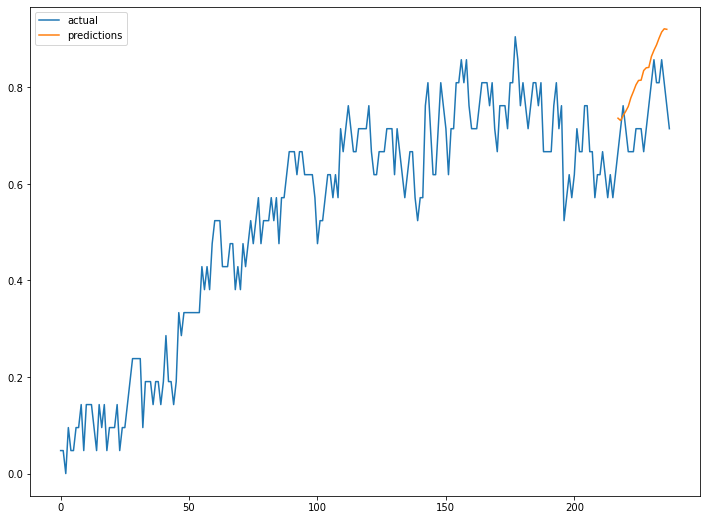

In [19]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 6.513819305264199 actual 0.8006535947712417 prediction 0.74850047
num 1 8.179037657476242 actual 0.8104575163398693 prediction 0.7441699
num 2 7.069088033882968 actual 0.8137254901960784 prediction 0.7562025
num 3 6.304221534729002 actual 0.8169934640522876 prediction 0.7654884
num 4 4.5147327899932845 actual 0.8169934640522876 prediction 0.7801084
num 5 3.140914392661285 actual 0.8202614379084967 prediction 0.7944977
num 6 1.6317315252402023 actual 0.826797385620915 prediction 0.8133063
num 7 1.7343730200081964 actual 0.8366013071895424 prediction 0.8220915
num 8 2.008900357029139 actual 0.8464052287581698 prediction 0.8294018
num 9 2.49083782064502 actual 0.8529411764705881 prediction 0.8316958
num 10 1.5285156978853565 actual 0.8594771241830064 prediction 0.8463399
num 11 0.8006575432690501 actual 0.8627450980392155 prediction 0.85583746
num 12 1.9660313624255847 actual 0.8660130718954246 prediction 0.848987
num 13 0.5332995810598918 actual 0.8660130718954246 prediction 0.8706

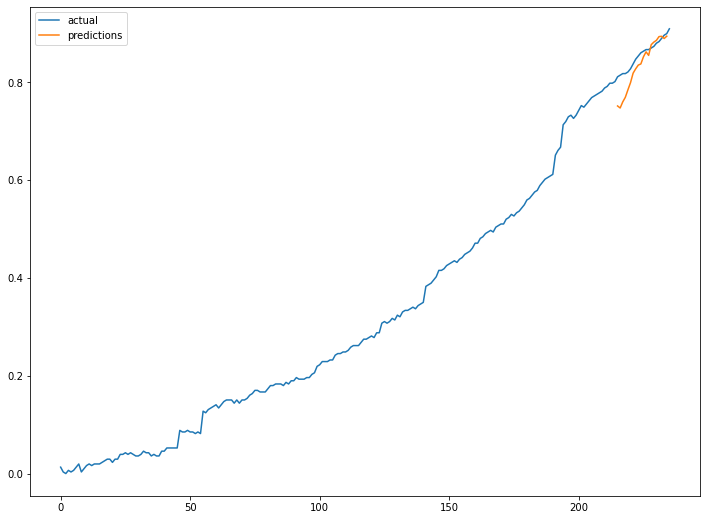

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.956834306127786 actual 0.6762402088772845 prediction 0.6827107
num 1 1.9283124217481171 actual 0.6892950391644908 prediction 0.6760033
num 2 2.194570155625907 actual 0.6971279373368144 prediction 0.681829
num 3 2.017371428500299 actual 0.702349869451697 prediction 0.68818086
num 4 1.7528385253849765 actual 0.7075718015665795 prediction 0.6951692
num 5 0.7163439353887212 actual 0.7154046997389034 prediction 0.71027994
num 6 1.3075120346520503 actual 0.7284595300261096 prediction 0.71893483
num 7 1.6436645293825543 actual 0.7389033942558747 prediction 0.7267583
num 8 2.321513874605539 actual 0.7493472584856395 prediction 0.73195106
num 9 2.62324304729183 actual 0.7545691906005221 prediction 0.734775
num 10 2.0072652414797028 actual 0.7650130548302871 prediction 0.7496572
num 11 1.811781667527706 actual 0.7676240208877285 prediction 0.75371635
num 12 1.7782997517358765 actual 0.7676240208877285 prediction 0.75397336
num 13 0.49647540854126215 actual 0.7780678851174934 prediction 0

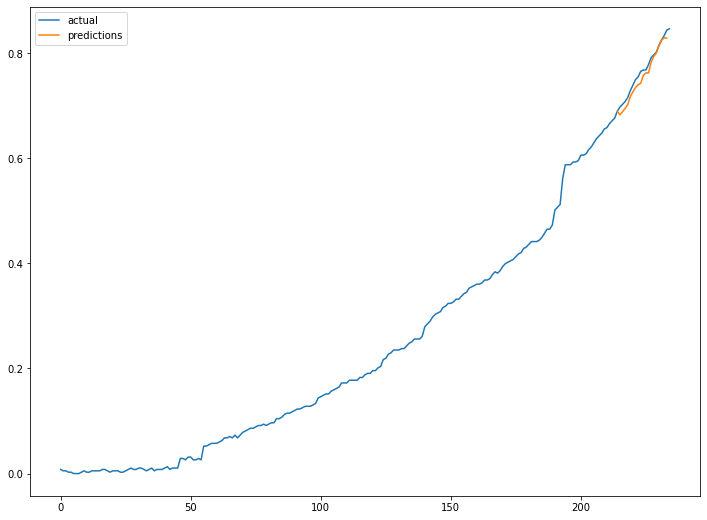

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 3.9887905120848894 actual 0.7916666666666661 prediction 0.76008874
num 1 4.956207777324405 actual 0.7916666666666661 prediction 0.75243
num 2 3.5926065946879424 actual 0.7916666666666661 prediction 0.7632252
num 3 3.614521026611328 actual 0.75 prediction 0.7771089
num 4 0.7732240777267406 actual 0.7916666666666661 prediction 0.797788
num 5 8.936039606730144 actual 0.75 prediction 0.8170203
num 6 0.12316465377800503 actual 0.8333333333333339 prediction 0.8343597
num 7 1.7547559738158456 actual 0.8333333333333339 prediction 0.8479563
num 8 6.06467073613941 actual 0.9166666666666661 prediction 0.86107385
num 9 9.564631918202332 actual 0.9583333333333339 prediction 0.8666723
num 10 7.915973663330135 actual 0.9583333333333339 prediction 0.8824719
num 11 6.707216345745643 actual 0.9583333333333339 prediction 0.89405584
num 12 6.790602725485155 actual 0.9583333333333339 prediction 0.8932567
num 13 4.172915997712567 actual 0.9583333333333339 prediction 0.9183429
num 14 1.5263904224743199

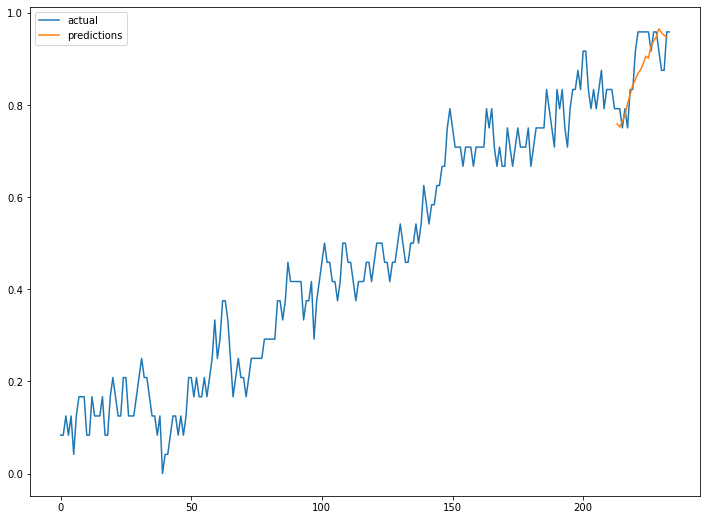

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.249231639661273 actual 0.8482142857142856 prediction 0.7782431
num 1 9.514416257540345 actual 0.8571428571428568 prediction 0.7755907
num 2 6.694393157958971 actual 0.8482142857142856 prediction 0.7914315
num 3 5.950223713020976 actual 0.8526785714285712 prediction 0.8019423
num 4 5.151160721926324 actual 0.8660714285714284 prediction 0.8214587
num 5 4.446486064365932 actual 0.875 prediction 0.83609325
num 6 2.0957849957616057 actual 0.8794642857142856 prediction 0.8610326
num 7 2.0474659138588027 actual 0.8883928571428568 prediction 0.8702033
num 8 0.5526388534391483 actual 0.8839285714285712 prediction 0.87904364
num 9 0.7652043098180911 actual 0.8883928571428568 prediction 0.88159484
num 10 1.312240446456784 actual 0.8839285714285712 prediction 0.89552784
num 11 1.8361091613769605 actual 0.8928571428571428 prediction 0.909251
num 12 0.42699964919889366 actual 0.901785714285714 prediction 0.8979351
num 13 1.6024359341325431 actual 0.90625 prediction 0.9207721
num 14 1.7752417

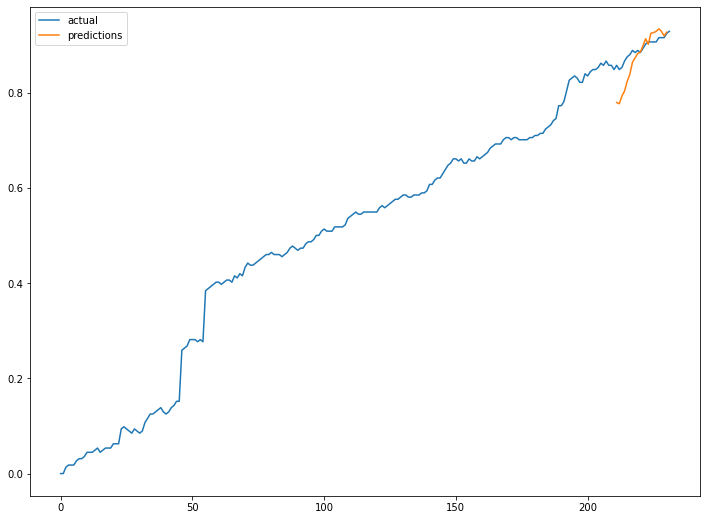

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 7.979348126579887 actual 0.8500000000000014 prediction 0.78217554
num 1 2.504123747348872 actual 0.8000000000000007 prediction 0.779967
num 2 6.1196962992350254 actual 0.75 prediction 0.7958977
num 3 7.400838534037272 actual 0.75 prediction 0.8055063
num 4 9.056838353474934 actual 0.75 prediction 0.8179263
num 5 10.31009356180827 actual 0.75 prediction 0.8273257
num 6 21.59307513918177 actual 0.7000000000000011 prediction 0.8511515
num 7 22.720522539956043 actual 0.7000000000000011 prediction 0.85904366
num 8 32.96463856330277 actual 0.6500000000000004 prediction 0.86427015
num 9 23.418373720986317 actual 0.7000000000000011 prediction 0.8639286
num 10 17.13259220123291 actual 0.75 prediction 0.87849444
num 11 18.24432214101156 actual 0.75 prediction 0.8868324
num 12 25.167131423950007 actual 0.7000000000000011 prediction 0.8761699
num 13 28.00605807985559 actual 0.7000000000000011 prediction 0.8960424
num 14 12.042412161826988 actual 0.8000000000000007 prediction 0.8963393
num 15

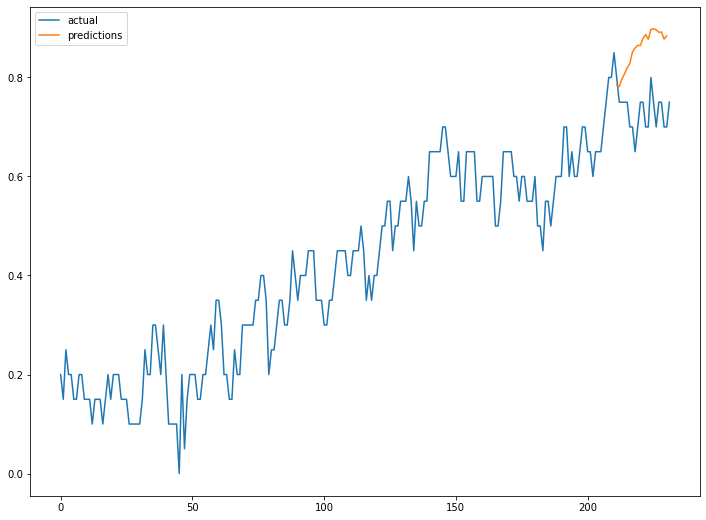

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 8.466318622231382 actual 0.8421052631578938 prediction 0.77080995
num 1 11.374070788874752 actual 0.8684210526315788 prediction 0.7696462
num 2 6.80347196757783 actual 0.8421052631578938 prediction 0.78481287
num 3 8.819142977396629 actual 0.8684210526315788 prediction 0.79183376
num 4 7.242177110729775 actual 0.8684210526315788 prediction 0.80552846
num 5 2.759292721748244 actual 0.8421052631578938 prediction 0.8188691
num 6 3.1943751919655115 actual 0.8157894736842097 prediction 0.84184885
num 7 4.238522052764994 actual 0.8157894736842097 prediction 0.8503669
num 8 1.7692092806101976 actual 0.8421052631578938 prediction 0.85700387
num 9 1.667349040508383 actual 0.8421052631578938 prediction 0.8561461
num 10 0.5065889069528506 actual 0.8684210526315788 prediction 0.8728204
num 11 4.803350567817804 actual 0.8421052631578938 prediction 0.88255453
num 12 2.575966189889311 actual 0.8947368421052628 prediction 0.8716887
num 13 2.80908165556014 actual 0.8684210526315788 prediction 0.8

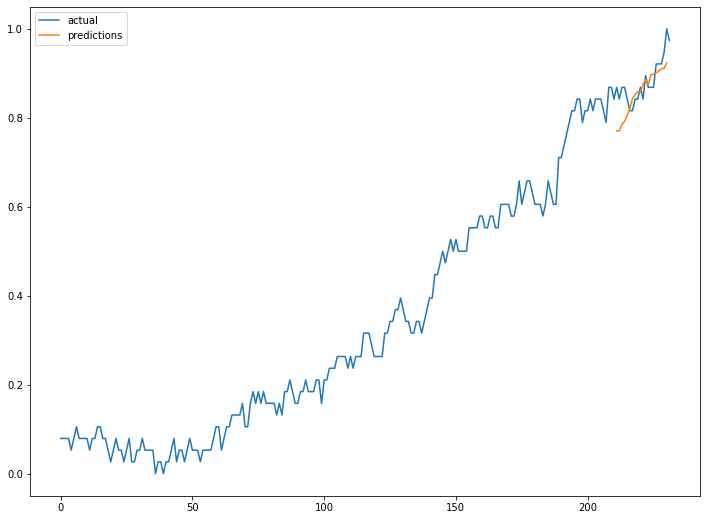

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 2.749574780464276 actual 0.76923076923077 prediction 0.7480802
num 1 2.0621299743651007 actual 0.7307692307692317 prediction 0.74583864
num 2 3.76864169773289 actual 0.7307692307692317 prediction 0.7583093
num 3 4.60020554693108 actual 0.7307692307692317 prediction 0.7643861
num 4 12.149365743001413 actual 0.6923076923076916 prediction 0.7764187
num 5 2.7809137105940676 actual 0.76923076923077 prediction 0.7906224
num 6 0.2679370698473854 actual 0.8076923076923084 prediction 0.8098564
num 7 1.274665196736568 actual 0.8076923076923084 prediction 0.8179877
num 8 2.581439234993738 actual 0.8461538461538467 prediction 0.8243109
num 9 2.036124184018003 actual 0.8076923076923084 prediction 0.8241379
num 10 9.329684972762944 actual 0.76923076923077 prediction 0.8409976
num 11 10.3874623775481 actual 0.76923076923077 prediction 0.8491343
num 12 9.328328967094304 actual 0.76923076923077 prediction 0.84098715
num 13 6.758662064870108 actual 0.8076923076923084 prediction 0.8622815
num 14 2.

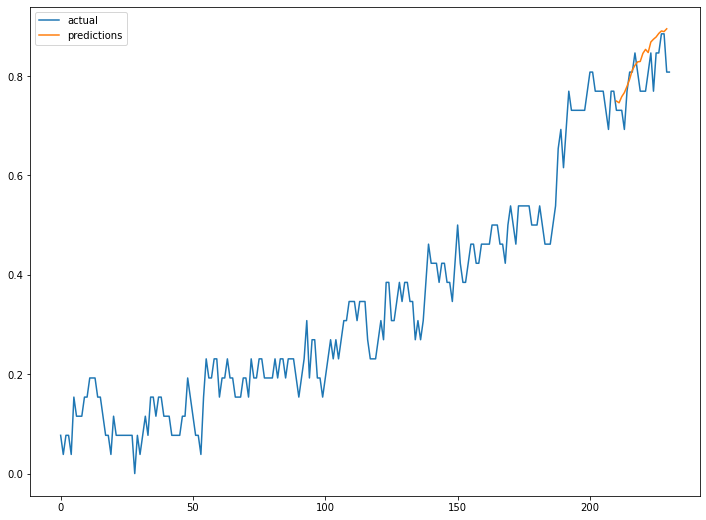

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 1.5739477475483896 actual 0.7389162561576352 prediction 0.7272861
num 1 3.550298629622707 actual 0.7487684729064039 prediction 0.72218496
num 2 2.907637716118759 actual 0.7536945812807878 prediction 0.7317799
num 3 2.5407352230765268 actual 0.7586206896551722 prediction 0.73934615
num 4 2.4865277302570767 actual 0.7684729064039408 prediction 0.7493646
num 5 1.359443300089266 actual 0.7733990147783252 prediction 0.7628851
num 6 0.10348886628690522 actual 0.7783251231527091 prediction 0.77751964
num 7 0.2861696219294556 actual 0.7832512315270934 prediction 0.78549266
num 8 0.3698704019188976 actual 0.7881773399014778 prediction 0.7910926
num 9 0.08090190265490046 actual 0.7931034482758621 prediction 0.7924618
num 10 1.2073060244690146 actual 0.798029556650246 prediction 0.8076642
num 11 1.9336864536191605 actual 0.798029556650246 prediction 0.81346095
num 12 0.15939924775101555 actual 0.8078817733990147 prediction 0.80916953
num 13 0.8089064481015971 actual 0.8226600985221673 predi

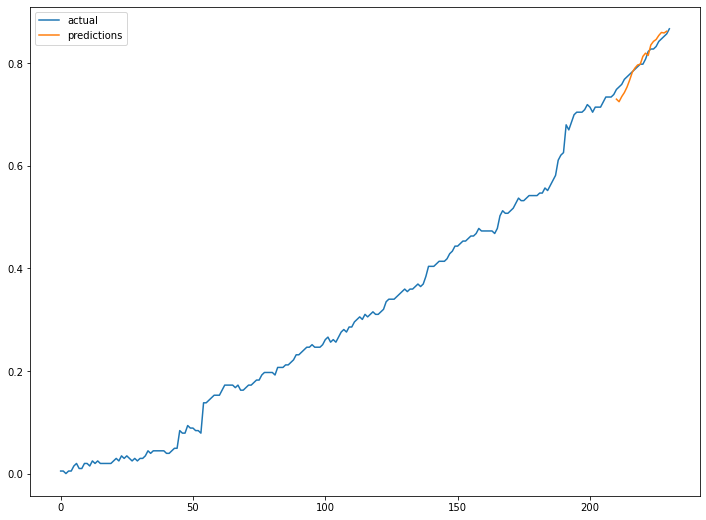

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()